# Customer Purchasing Behavior Analysis

## Assignment Overview

This comprehensive analysis examines customer purchasing patterns from a UK-based online retail dataset using advanced machine learning techniques. The assignment integrates three major analytical approaches:

1. **Customer Clustering**: Segment customers based on purchasing behavior (spending, frequency, basket size)
2. **Deep Learning Embeddings**: Apply autoencoders to discover non-linear customer patterns
3. **Association Rule Mining**: Identify frequently co-purchased product combinations

## Business Objectives

- Identify distinct customer segments for targeted marketing
- Discover high-value customer populations
- Uncover product affinity patterns for cross-selling opportunities
- Compare traditional (PCA) vs. modern (deep learning) dimensionality reduction techniques
- Provide actionable business recommendations based on data insights

## Dataset Information

- **Source**: Online Retail II Dataset (UK-based e-commerce)
- **Time Period**: Retail transactions over multiple years
- **Initial Records**: 1,067,371 transactions
- **Data Quality**: Includes cancelled orders, missing descriptions, and negative quantities
- **Key Features**: Customer ID, Product Description, Quantity, Price, Transaction Date
- **Processing**: Cleaned to remove invalid records, resulting in 1,042,727 valid transactions
- **Customers**: 5,881 unique customers analyzed
- **Products**: 5,426 unique product items identified

## Notebook Structure

This notebook is organized into **4 main parts** with clear step-by-step progression:

- **Part A**: Data Cleaning & Customer Clustering (k-Means & DBSCAN)
- **Part B**: Deep Embedding Clustering (Autoencoder + k-Means)
- **Part C**: Association Rule Mining (Apriori Algorithm)
- **Part D**: Interpretation & Business Recommendations

---

#### Load all required libraries


In [1]:
# Load required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras import layers, models

from mlxtend.frequent_patterns import fpgrowth, association_rules

import warnings
warnings.filterwarnings("ignore")

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (8, 6)
print("Successfully imported libraries")


Successfully imported libraries


## Part A: Data Cleaning and Clustering

This section covers:
1. Load dataset
2. Remove missing descriptions, negative quantities, and cancelled invoices
3. Create customer-level features (total spending, transaction count, avg basket size)
4. Apply k-Means and DBSCAN clustering
5. Compute silhouette scores and visualize with PCA

### A1. Load Dataset

In [2]:
# Load the dataset
file_path = "online_retail_II.csv"
df = pd.read_csv(file_path)

print("Shape:", df.shape)
df.head()


Shape: (1067371, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


### A1.2. Dataset Information and Statistics

In [3]:
# Display dataset information and statistics
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


,Quantity,Price,Customer ID
count,1.067371e+06,1.067371e+06,824364.000000
mean,9.938898e+00,4.649388e+00,15324.638504
std,1.727058e+02,1.235531e+02,1697.464450
min,-8.099500e+04,-5.359436e+04,12346.000000
25%,1.000000e+00,1.250000e+00,13975.000000
50%,3.000000e+00,2.100000e+00,15255.000000
75%,1.000000e+01,4.150000e+00,16797.000000
max,8.099500e+04,3.897000e+04,18287.000000


### A2. Clean the Data

Remove missing descriptions, negative quantities, and cancelled invoices (starting with "C")


In [4]:
df_clean = df.copy()
df_clean.columns = [col.strip().replace(" ", "") for col in df_clean.columns]

df_clean = df_clean.dropna(subset=["Description"])
df_clean = df_clean[df_clean["Quantity"] > 0]
df_clean = df_clean[~df_clean["Invoice"].astype(str).str.startswith("C")]
df_clean["TotalPrice"] = df_clean["Quantity"] * df_clean["Price"]

print("Original shape:", df.shape)
print("Cleaned shape:", df_clean.shape)
print("Removed rows:", df.shape[0] - df_clean.shape[0])
df_clean.head(5)


Original shape: (1067371, 8)
Cleaned shape: (1042727, 9)
Removed rows: 24644


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


### A3. Create Customer-level Features

Create total spending, transaction count, and average basket size per customer

In [5]:
# Aggregate customer-level features: TotalSpending, TransactionCount, AvgBasketSize
if 'TotalPrice' not in df_clean.columns and {'Quantity','UnitPrice'}.issubset(df_clean.columns):
    df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['UnitPrice']

customer_df = (
    df_clean
    .groupby("CustomerID")
    .agg(
        TotalSpending=("TotalPrice", "sum"),
        TransactionCount=("Invoice", "nunique"),
        TotalQty=("Quantity", "sum")
    )
    .reset_index()
)

customer_df["AvgBasketSize"] = (
    customer_df["TotalQty"] / customer_df["TransactionCount"].replace({0: np.nan})
)

print("Customers aggregated:", customer_df.shape[0])
display(customer_df.head(10))


Customers aggregated: 5881


,CustomerID,TotalSpending,TransactionCount,TotalQty,AvgBasketSize
0,12346.0,77556.46,12,74285,6190.416667
1,12347.0,5633.32,8,3286,410.750000
2,12348.0,2019.40,5,2714,542.800000
3,12349.0,4428.69,4,1624,406.000000
4,12350.0,334.40,1,197,197.000000
5,12351.0,300.93,1,261,261.000000
6,12352.0,2849.84,10,724,72.400000
7,12353.0,406.76,2,212,106.000000
8,12354.0,1079.40,1,530,530.000000
9,12355.0,947.61,2,543,271.500000


### A3.2. Prepare Features for Clustering

Scale features and prepare feature matrix for clustering algorithms

### A4. Apply k-Means and DBSCAN Clustering

Apply clustering algorithms and compute silhouette scores

In [6]:
# Prepare feature matrix: TotalSpending, TransactionCount, AvgBasketSize
features_kmeans = ["TotalSpending", "TransactionCount", "AvgBasketSize"]
X_kmeans = customer_df[features_kmeans].fillna(0).values

# Scale features for clustering
scaler_kmeans = StandardScaler()
X_scaled_kmeans = scaler_kmeans.fit_transform(X_kmeans)

print("Feature preparation for k-Means and DBSCAN:")
print(f"Features: {features_kmeans}")
print(f"X_scaled_kmeans shape: {X_scaled_kmeans.shape}")
print(f"\nFirst 5 rows of scaled features:")
print(pd.DataFrame(X_scaled_kmeans[:5], columns=features_kmeans))
print()

X_scaled = X_scaled_kmeans


Feature preparation for k-Means and DBSCAN:
Features: ['TotalSpending', 'TransactionCount', 'AvgBasketSize']
X_scaled_kmeans shape: (5881, 3)

First 5 rows of scaled features:
   TotalSpending  TransactionCount  AvgBasketSize
0       5.059391          0.439049       4.142494
1       0.177579          0.131635       0.109969
2      -0.067718         -0.098925       0.202101
3       0.095814         -0.175779       0.106655
4      -0.182088         -0.406339      -0.039166



#### A4.1. k-Means Clustering - Parameter Tuning

k-MEANS CLUSTERING - Parameter Tuning
__________________________________________________________________________________________


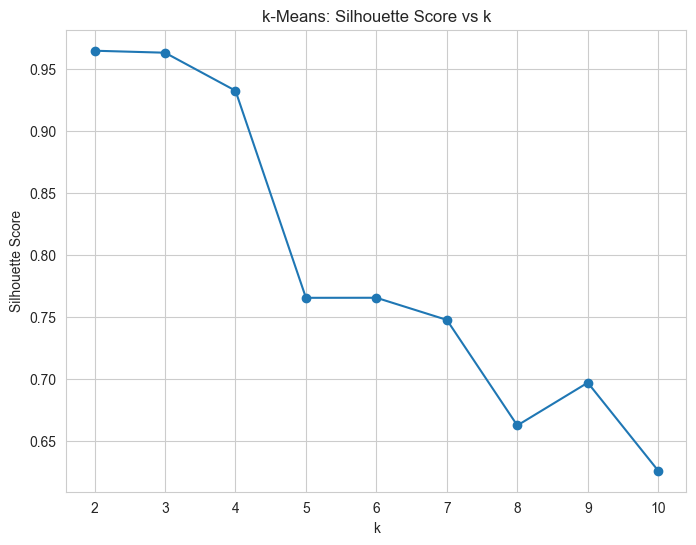


Silhouette scores for k=2..10:
  k=2: 0.9645 <-- OPTIMAL
  k=3: 0.9629
  k=4: 0.9323
  k=5: 0.7655
  k=6: 0.7655
  k=7: 0.7477
  k=8: 0.6626
  k=9: 0.6971
  k=10: 0.6261

------------------------------------------------------------------------------------------
k-MEANS FINAL RESULTS:
  Selected k: 2
  Number of clusters: 2
  Silhouette Score: 0.9645


In [7]:
# Tune k-Means: find optimal number of clusters using silhouette scores
print("k-MEANS CLUSTERING - Parameter Tuning")
print("_" * 90)
sil_scores = []
K_range = range(2, 11) 

for kk in K_range:
    km = KMeans(n_clusters=kk, random_state=42, n_init=10).fit(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, km.labels_))

plt.figure(figsize=(8, 6))
plt.plot(list(K_range), sil_scores, marker='o')
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.title("k-Means: Silhouette Score vs k")
plt.grid(True)
plt.show()

optimal_k = K_range[np.argmax(sil_scores)]
print(f"\nSilhouette scores for k=2..10:")
for k_val, sil_val in zip(K_range, sil_scores):
    marker = " <-- OPTIMAL" if k_val == optimal_k else ""
    print(f"  k={k_val}: {sil_val:.4f}{marker}")

# Apply k-Means with optimal k
k = optimal_k
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
customer_df["kmeans_cluster"] = kmeans.fit_predict(X_scaled)

n_clusters_kmeans = len(set(customer_df["kmeans_cluster"]))
sil_kmeans = silhouette_score(X_scaled, customer_df["kmeans_cluster"])

print("\n" + "-" * 90)
print("k-MEANS FINAL RESULTS:")
print(f"  Selected k: {k}")
print(f"  Number of clusters: {n_clusters_kmeans}")
print(f"  Silhouette Score: {sil_kmeans:.4f}")


**Interpretation:** The silhouette score plot shows the optimal number of clusters for k-Means. We tested k values from 2 to 10 and selected the k with the highest silhouette score. The optimal k value indicates the number of distinct customer segments that best separate the data while maintaining internal cluster cohesion.


DBSCAN CLUSTERING - Parameter Tuning
______________________________________________________________________


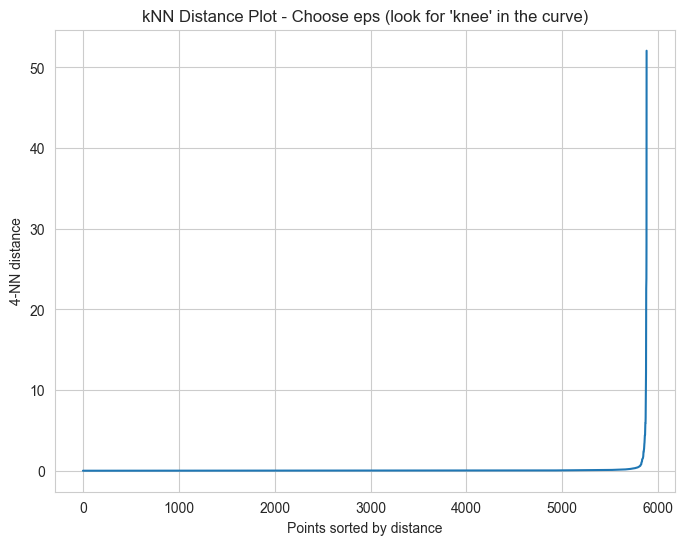


Testing different eps values for DBSCAN:
  eps=0.3: 3 clusters, 101 noise points, silhouette=0.6912 <-- OPTIMAL
  eps=0.5: 1 clusters, 69 noise points, silhouette=not meaningful
  eps=0.7: 2 clusters, 55 noise points, silhouette=0.8754 <-- OPTIMAL
  eps=1.0: 1 clusters, 54 noise points, silhouette=not meaningful
  eps=1.5: 1 clusters, 36 noise points, silhouette=not meaningful

----------------------------------------------------------------------
DBSCAN FINAL RESULTS:
  Selected eps: 0.7
  Number of clusters: 2
  Noise points: 55
  Silhouette Score: 0.8754 (excluding noise)


In [8]:
# Tune DBSCAN: find optimal eps parameter using kNN distance plot
print("DBSCAN CLUSTERING - Parameter Tuning")
print("_" * 70)

neigh = NearestNeighbors(n_neighbors=5).fit(X_scaled)
dists, _ = neigh.kneighbors(X_scaled)
dists = np.sort(dists[:, 4])

plt.figure(figsize=(8, 6))
plt.plot(dists)
plt.ylabel("4-NN distance")
plt.xlabel("Points sorted by distance")
plt.title("kNN Distance Plot - Choose eps (look for 'knee' in the curve)")
plt.grid(True)
plt.show()

print("\nTesting different eps values for DBSCAN:")
eps_values = [0.3, 0.5, 0.7, 1.0, 1.5]
best_eps = 0.7
best_sil = -1
best_n_clusters = 0
best_n_noise = 0

for eps_val in eps_values:
    dbscan_test = DBSCAN(eps=eps_val, min_samples=5)
    labels_test = dbscan_test.fit_predict(X_scaled)
    n_clusters = len(set(labels_test)) - (1 if -1 in labels_test else 0)
    n_noise = list(labels_test).count(-1)
    
    valid_mask = labels_test != -1
    if len(set(labels_test[valid_mask])) > 1:
        sil_test = silhouette_score(X_scaled[valid_mask], labels_test[valid_mask])
        marker = " <-- OPTIMAL" if sil_test > best_sil else ""
        print(f"  eps={eps_val:.1f}: {n_clusters} clusters, {n_noise} noise points, silhouette={sil_test:.4f}{marker}")
        if sil_test > best_sil:
            best_sil = sil_test
            best_eps = eps_val
            best_n_clusters = n_clusters
            best_n_noise = n_noise
    else:
        print(f"  eps={eps_val:.1f}: {n_clusters} clusters, {n_noise} noise points, silhouette=not meaningful")

# Apply DBSCAN with optimal eps
dbscan = DBSCAN(eps=best_eps, min_samples=5)
customer_df["dbscan_cluster"] = dbscan.fit_predict(X_scaled)

labels_db = customer_df["dbscan_cluster"].values
valid_mask = labels_db != -1
n_clusters_dbscan = len(set(labels_db)) - (1 if -1 in labels_db else 0)
n_noise_dbscan = list(labels_db).count(-1)

if len(set(labels_db[valid_mask])) > 1:
    sil_dbscan = silhouette_score(X_scaled[valid_mask], labels_db[valid_mask])
    print(f"\n" + "-" * 70)
    print("DBSCAN FINAL RESULTS:")
    print(f"  Selected eps: {best_eps}")
    print(f"  Number of clusters: {n_clusters_dbscan}")
    print(f"  Noise points: {n_noise_dbscan}")
    print(f"  Silhouette Score: {sil_dbscan:.4f} (excluding noise)")


In [9]:
# Compare k-Means and DBSCAN clustering results
print("CLUSTERING METHODS COMPARISON")
print("_" * 70)

n_clusters_kmeans = len(set(customer_df["kmeans_cluster"]))
sil_kmeans = silhouette_score(X_scaled, customer_df["kmeans_cluster"])

labels_db = customer_df["dbscan_cluster"].values
valid_mask = labels_db != -1
n_clusters_dbscan = len(set(labels_db)) - (1 if -1 in labels_db else 0)
n_noise_dbscan = list(labels_db).count(-1)

if len(set(labels_db[valid_mask])) > 1:
    sil_dbscan = silhouette_score(X_scaled[valid_mask], labels_db[valid_mask])
    sil_dbscan_str = f"{sil_dbscan:.4f}"
else:
    sil_dbscan_str = "N/A (not meaningful)"

print(f"\n{'Metric':<30} {'k-Means':<20} {'DBSCAN':<20}")
print("-" * 70)
print(f"{'Number of clusters':<30} {n_clusters_kmeans:<20} {n_clusters_dbscan:<20}")
print(f"{'Silhouette Score':<30} {sil_kmeans:.4f}{'':<16} {sil_dbscan_str:<20}")
print(f"{'Noise points':<30} {'N/A (all assigned)':<20} {n_noise_dbscan:<20}")


CLUSTERING METHODS COMPARISON
______________________________________________________________________

Metric                         k-Means              DBSCAN              
----------------------------------------------------------------------
Number of clusters             2                    2                   
Silhouette Score               0.9645                 0.8754              
Noise points                   N/A (all assigned)   55                  


### A5. Visualize Clusters with PCA

Compute silhouette scores and visualize clusters using PCA projections

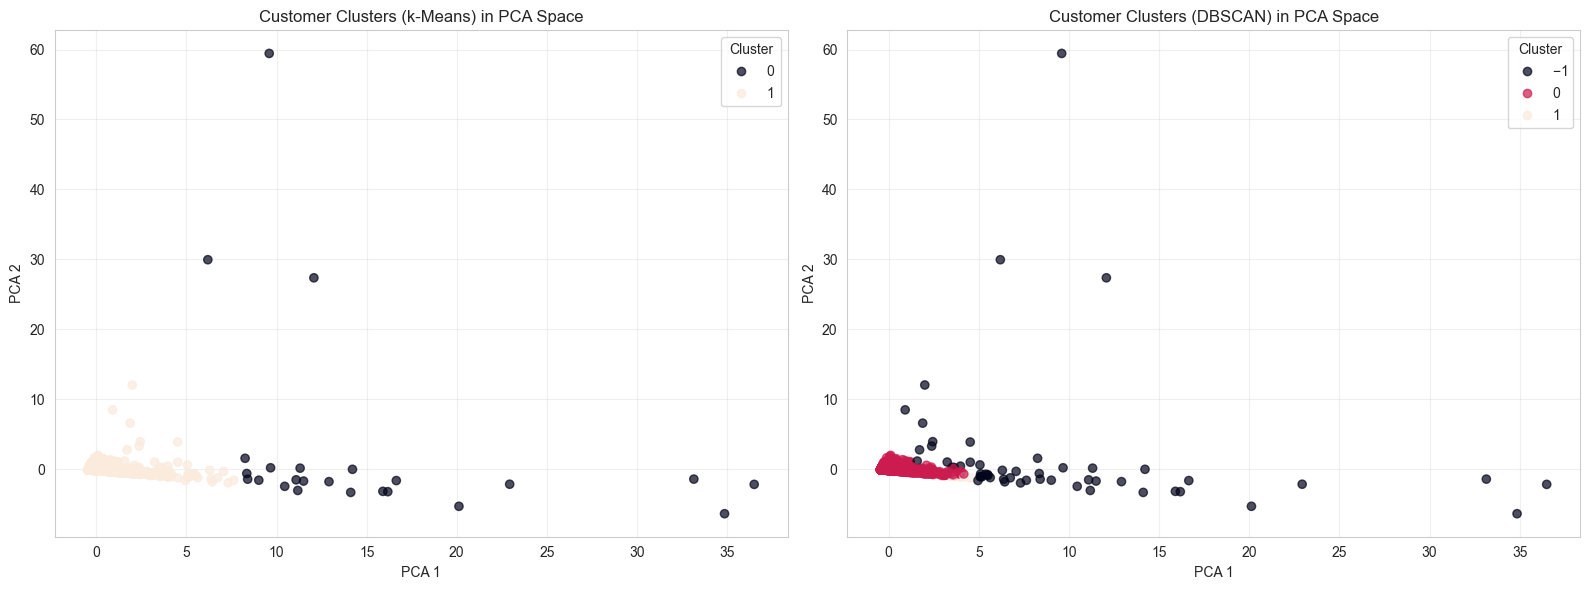

In [10]:
# Visualize clusters using PCA 2D projection
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

scatter1 = ax1.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=customer_df["kmeans_cluster"],
    alpha=0.7
)
ax1.set_xlabel("PCA 1")
ax1.set_ylabel("PCA 2")
ax1.set_title("Customer Clusters (k-Means) in PCA Space")
ax1.legend(*scatter1.legend_elements(), title="Cluster")
ax1.grid(True, alpha=0.3)

scatter2 = ax2.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=customer_df["dbscan_cluster"],
    alpha=0.7
)
ax2.set_xlabel("PCA 1")
ax2.set_ylabel("PCA 2")
ax2.set_title("Customer Clusters (DBSCAN) in PCA Space")
ax2.legend(*scatter2.legend_elements(), title="Cluster")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


**Interpretation:** The PCA plots show that k-Means produces well-separated clusters by assigning all data points to a cluster. DBSCAN forms clusters based on density and identifies outliers as noise, making it more robust to irregular data distributions.

#### Interpretation of k-Means vs DBSCAN Clustering Results


In [11]:
# Interpretation of k-Means vs DBSCAN Clustering Results


n_clusters_kmeans = len(set(customer_df["kmeans_cluster"]))
n_clusters_dbscan = len(set(customer_df["dbscan_cluster"])) - (1 if -1 in customer_df["dbscan_cluster"].values else 0)
n_noise_dbscan = list(customer_df["dbscan_cluster"].values).count(-1)

print(f"\n1. k-Means ({n_clusters_kmeans} clusters): Each color = different customer segment. All customers assigned (no outliers).")
print(f"2. DBSCAN ({n_clusters_dbscan} clusters + {n_noise_dbscan} noise): Colors = dense groups. Black = outliers/unusual patterns.")



1. k-Means (2 clusters): Each color = different customer segment. All customers assigned (no outliers).
2. DBSCAN (2 clusters + 55 noise): Colors = dense groups. Black = outliers/unusual patterns.


## Part B: Deep Embedding Clustering

Build an autoencoder to extract latent embeddings, then cluster them with k-Means. Provide embedding plots and compare cluster quality with PCA clusters.


#### B1.1. Autoencoder architecture

In [12]:
# Build autoencoder architecture for deep embedding clustering
input_dim = X_scaled.shape[1]
encoding_dim = 2

input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(8, activation="relu")(input_layer)
bottleneck = layers.Dense(encoding_dim, activation="relu", name="bottleneck")(encoded)
decoded = layers.Dense(8, activation="relu")(bottleneck)
output_layer = layers.Dense(input_dim, activation="linear")(decoded)

autoencoder = models.Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer="adam", loss="mse")

autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 2)              │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101 (404.00 B)

 Trainable params: 101 (404.00 B)

 Non-trainable params: 0 (0.00 B)

#### B1.2. Train autoencoder

Epoch 1/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.9598 - val_loss: 1.6907
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9128 - val_loss: 1.6398
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8847 - val_loss: 1.5975
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8504 - val_loss: 1.5612
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8132 - val_loss: 1.5095
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7672 - val_loss: 1.4480
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7100 - val_loss: 1.3703
Epoch 8/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6467 - val_loss: 1.2759
Epoch 9/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5705 - val_loss: 1.1615
Epoch 10/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4927 - val_loss: 1.0618
Epoch 11/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4197 - val_loss: 0.9546
Epoch 12/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.

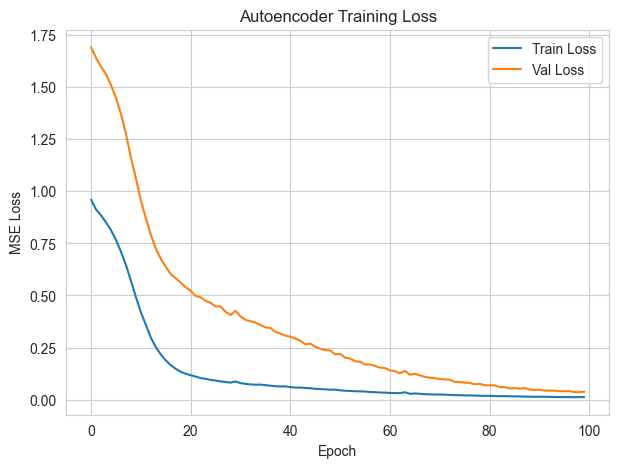

In [13]:
# Train the autoencoder
history = autoencoder.fit(
    X_scaled, X_scaled,
    epochs=100,
    batch_size=128,
    validation_split=0.1,
    verbose=1
)

plt.figure(figsize=(7, 5))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Autoencoder Training Loss")
plt.legend()
plt.show()


#### B2. Getting embeddings and clustering & Compare cluster quality
B2.1. Extract latent embeddings from the trained autoencoder and apply k-Means clustering and Visualising latent space

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Autoencoder Embedding k-Means Silhouette Score: 0.9839


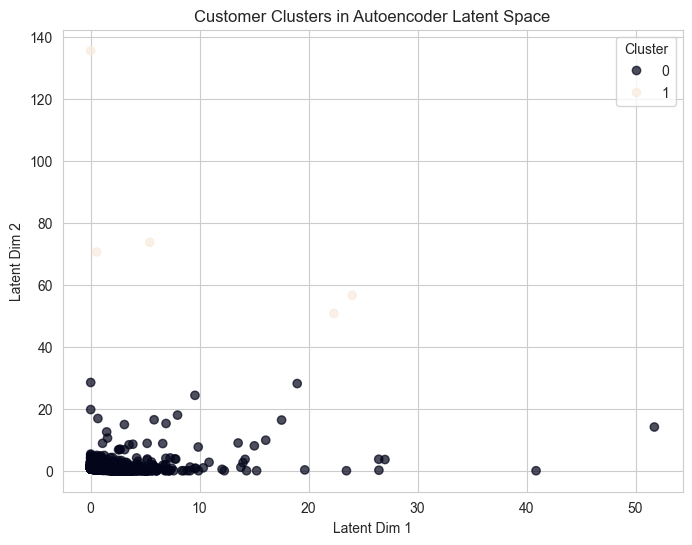

In [14]:
# Extract latent embeddings from trained autoencoder
encoder = models.Model(inputs=autoencoder.input,
                outputs=autoencoder.get_layer("bottleneck").output)

embeddings = encoder.predict(X_scaled)

# Apply k-Means clustering on latent embeddings
kmeans_ae = KMeans(n_clusters=k, random_state=42, n_init=10)
customer_df["ae_cluster"] = kmeans_ae.fit_predict(embeddings)

sil_ae = silhouette_score(embeddings, customer_df["ae_cluster"])
print(f"Autoencoder Embedding k-Means Silhouette Score: {sil_ae:.4f}")

# Visualize embeddings and clusters
plt.figure(figsize=(8, 6))
scatter_ae = plt.scatter(embeddings[:, 0], embeddings[:, 1],
                         c=customer_df["ae_cluster"], alpha=0.7)
plt.xlabel("Latent Dim 1")
plt.ylabel("Latent Dim 2")
plt.title("Customer Clusters in Autoencoder Latent Space")
plt.legend(*scatter_ae.legend_elements(), title="Cluster")
plt.show()



B2.2. Silhouette Score Comparison on clustering quality: k-Means on PCA vs Autoencoder embeddings

In [15]:
# Compare clustering quality: PCA vs Autoencoder embeddings
pca_2d = PCA(n_components=2, random_state=42)
X_pca_2d = pca_2d.fit_transform(X_scaled)

kmeans_pca = KMeans(n_clusters=k, random_state=42, n_init=10)
customer_df["kmeans_pca_cluster"] = kmeans_pca.fit_predict(X_pca_2d)

sil_pca = silhouette_score(X_pca_2d, customer_df["kmeans_pca_cluster"])
sil_ae = silhouette_score(embeddings, customer_df["ae_cluster"])

print("SILHOUETTE SCORE COMPARISON")
print("_" * 45)
print(f"k-Means on PCA (2D):        {sil_pca:.4f}")
print(f"k-Means on Autoencoder embeddings: {sil_ae:.4f}")
print("-" * 45)
print(f"Difference:                  {abs(sil_ae - sil_pca):.4f}")
if sil_ae > sil_pca:
    print(f"Autoencoder embeddings perform better by {((sil_ae - sil_pca) / sil_pca * 100):.2f}%")
else:
    print(f"PCA performs better by {((sil_pca - sil_ae) / sil_ae * 100):.2f}%")


SILHOUETTE SCORE COMPARISON
_____________________________________________
k-Means on PCA (2D):        0.9659
k-Means on Autoencoder embeddings: 0.9839
---------------------------------------------
Difference:                  0.0180
Autoencoder embeddings perform better by 1.86%


##### B3. Visual comparison: Side-by-side plots of PCA vs Autoencoder embeddings

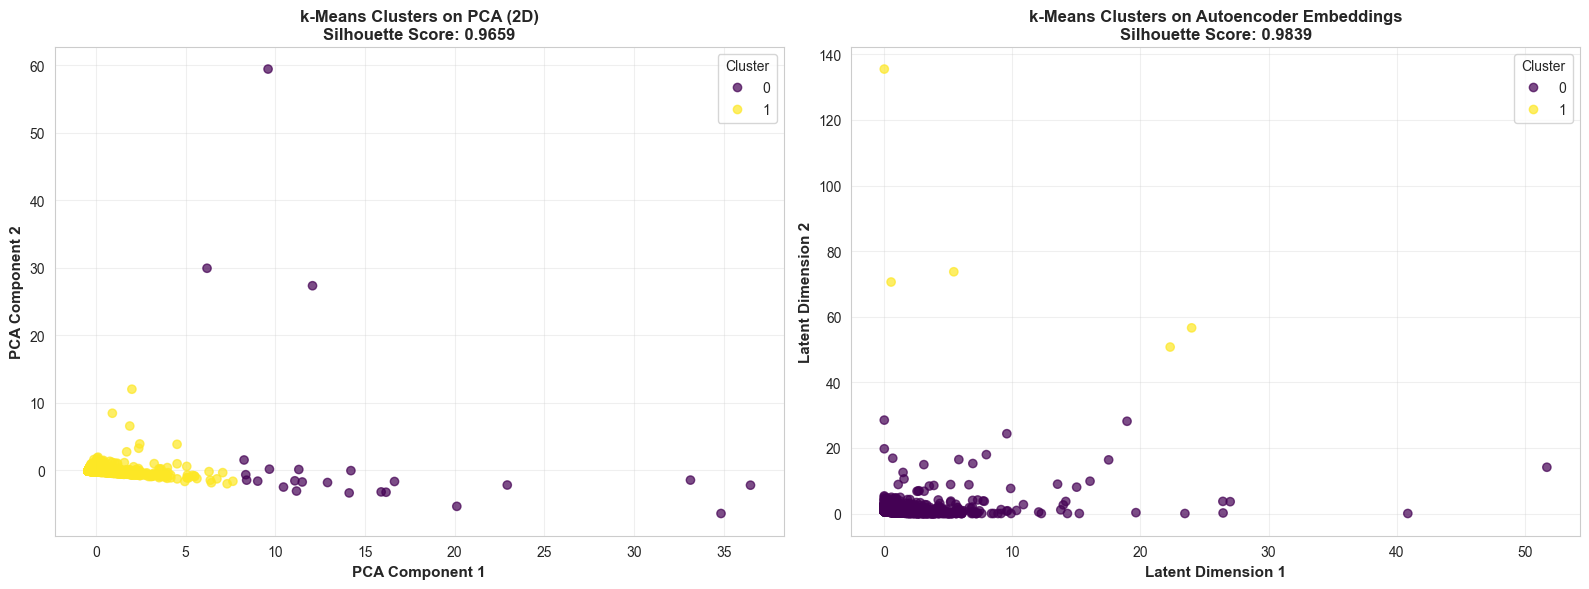

In [16]:
# Visual comparison: PCA vs Autoencoder embeddings
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

scatter1 = ax1.scatter(
    X_pca_2d[:, 0],
    X_pca_2d[:, 1],
    c=customer_df["kmeans_pca_cluster"],
    alpha=0.7,
    cmap='viridis'
)
ax1.set_xlabel("PCA Component 1", fontsize=11, fontweight='bold')
ax1.set_ylabel("PCA Component 2", fontsize=11, fontweight='bold')
ax1.set_title(f"k-Means Clusters on PCA (2D)\nSilhouette Score: {sil_pca:.4f}", fontsize=12, fontweight='bold')
ax1.legend(*scatter1.legend_elements(), title="Cluster", loc='upper right')
ax1.grid(True, alpha=0.3)

scatter2 = ax2.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    c=customer_df["ae_cluster"],
    alpha=0.7,
    cmap='viridis'
)
ax2.set_xlabel("Latent Dimension 1", fontsize=11, fontweight='bold')
ax2.set_ylabel("Latent Dimension 2", fontsize=11, fontweight='bold')
ax2.set_title(f"k-Means Clusters on Autoencoder Embeddings\nSilhouette Score: {sil_ae:.4f}", fontsize=12, fontweight='bold')
ax2.legend(*scatter2.legend_elements(), title="Cluster", loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Part C: Association Rule Mining


### 1. Convert Data into Basket Format

Convert data into basket format: Invoice to a list of Description items.

In [33]:
# Convert data into basket format: Invoice to a list of Description items
basket_df = (
    df_clean[["Invoice", "Description", "Quantity"]]
    .copy()
)

print("Basket format data preview:")
basket_df.head()


Basket format data preview:


,Invoice,Description,Quantity
0,489434,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12
1,489434,PINK CHERRY LIGHTS,12
2,489434,WHITE CHERRY LIGHTS,12
3,489434,"RECORD FRAME 7"" SINGLE SIZE",48
4,489434,STRAWBERRY CERAMIC TRINKET BOX,24


### 2. Build Binary Matrix

Build binary matrix with Invoice as rows and Description as columns.

In [34]:
# Build binary matrix: Invoice as rows, Description as columns (True/False)
basket = (
    basket_df
    .groupby(["Invoice", "Description"])["Quantity"]
    .sum()
    .unstack()
    .fillna(0)
)

basket_bool = basket > 0

print("Binary Matrix Created:")
print(f"Shape: {basket_bool.shape[0]} invoices × {basket_bool.shape[1]} products")
print(f"\nFirst 5 rows:")
basket_bool.head()


Binary Matrix Created:
Shape: 40301 invoices × 5469 products

First 5 rows:


Description,DOORMAT UNION JACK GUNS AND ROSES,3 STRIPEY MICE FELTCRAFT,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,ANIMAL STICKERS,BLACK PIRATE TREASURE CHEST,BROWN PIRATE TREASURE CHEST,Bank Charges,CAMPHOR WOOD PORTOBELLO MUSHROOM,CHERRY BLOSSOM DECORATIVE FLASK,...,tk maxx mix up with pink,to push order througha s stock was,update,website fixed,wrong invc,wrongly coded 20713,wrongly coded 23343,wrongly marked,wrongly marked 23343,wrongly sold (22719) barcode
Invoice,,,,,,,,,,,,,,,,,,,,,
489434,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
489435,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
489436,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
489437,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
489438,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### 3. Apply FP-Growth

Apply FP-Growth algorithm to find frequent itemsets. 


In [35]:
# Apply FP-Growth algorithm to find frequent itemsets
frequent_itemsets = fpgrowth(
    basket_bool,
    min_support=0.01,
    use_colnames=True
)

print("Number of frequent itemsets:", len(frequent_itemsets))
print("\nTop 10 frequent itemsets:")
frequent_itemsets.head(10)


Number of frequent itemsets: 1056

Top 10 frequent itemsets:


,support,itemsets
0,0.057319,(STRAWBERRY CERAMIC TRINKET BOX)
1,0.019330,(SAVE THE PLANET MUG)
2,0.017220,(PINK DOUGHNUT TRINKET POT )
3,0.013771,"(RECORD FRAME 7"" SINGLE SIZE )"
4,0.012828,(15CM CHRISTMAS GLASS BALL 20 LIGHTS)
5,0.069676,(ASSORTED COLOUR BIRD ORNAMENT)
6,0.051264,(HOME BUILDING BLOCK WORD)
7,0.042083,(LOVE BUILDING BLOCK WORD)
8,0.041910,(SCOTTIE DOG HOT WATER BOTTLE)
9,0.020669,(HEART IVORY TRELLIS LARGE)


### 4. Extract the 10 Strongest Rules Sorted by Lift

Extract the 10 strongest rules sorted by lift.

In [ ]:
# Extract the 10 strongest rules sorted by lift
if 'frequent_itemsets' not in globals():
    raise NameError("Please run Cell 42 (Step 3) first to create frequent_itemsets.")

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)
top_rules = rules.sort_values("lift", ascending=False).head(10)

print("TOP 10 STRONGEST ASSOCIATION RULES (Sorted by Lift)")
print("_" * 105)
print(f"\nTotal rules generated: {len(rules)}")
print(f"\nTop 10 rules:\n")
print(top_rules[["antecedents", "consequents", "support", "confidence", "lift"]].to_string())


TOP 10 STRONGEST ASSOCIATION RULES (Sorted by Lift)
_________________________________________________________________________________________________________

Total rules generated: 848

Top 10 rules:

                                                     antecedents                                                  consequents   support  confidence       lift
809                              (POPPY'S PLAYHOUSE LIVINGROOM )      (POPPY'S PLAYHOUSE BEDROOM , POPPY'S PLAYHOUSE KITCHEN)  0.010149    0.725177  52.469247
804      (POPPY'S PLAYHOUSE BEDROOM , POPPY'S PLAYHOUSE KITCHEN)                              (POPPY'S PLAYHOUSE LIVINGROOM )  0.010149    0.734291  52.469247
807                                 (POPPY'S PLAYHOUSE BEDROOM )   (POPPY'S PLAYHOUSE KITCHEN, POPPY'S PLAYHOUSE LIVINGROOM )  0.010149    0.581792  49.465849
806   (POPPY'S PLAYHOUSE KITCHEN, POPPY'S PLAYHOUSE LIVINGROOM )                                 (POPPY'S PLAYHOUSE BEDROOM )  0.010149    0.862869  49.465849
805

### 5. Interpret at Least 3 Rules

Interpret at least 3 rules.

In [38]:
# Interpret at least 3 association rules
def frozenset_to_str(fset):
    return ", ".join(list(fset))

np.random.seed(42)
sampled_rules = top_rules.sample(n=min(4, len(top_rules)), random_state=42)

print("4 ASSOCIATION RULES FOR INTERPRETATION")
print("_" * 115)
print()

for i, (idx, row) in enumerate(sampled_rules.iterrows(), 1):
    antecedents = frozenset_to_str(row["antecedents"])
    consequents = frozenset_to_str(row["consequents"])
    print(f"Rule {i}: IF a customer buys [{antecedents}] THEN they also tend to buy [{consequents}]")
    print(f"  Support:   {row['support']:.4f}")
    print(f"  Confidence: {row['confidence']:.4f}")
    print(f"  Lift:      {row['lift']:.4f}")
    print("-" * 115)


4 ASSOCIATION RULES FOR INTERPRETATION
___________________________________________________________________________________________________________________

Rule 1: IF a customer buys [POPPY'S PLAYHOUSE LIVINGROOM ] THEN they also tend to buy [POPPY'S PLAYHOUSE KITCHEN]
  Support:   0.0118
  Confidence: 0.8404
  Lift:      45.6469
-------------------------------------------------------------------------------------------------------------------
Rule 2: IF a customer buys [POPPY'S PLAYHOUSE BEDROOM , POPPY'S PLAYHOUSE KITCHEN] THEN they also tend to buy [POPPY'S PLAYHOUSE LIVINGROOM ]
  Support:   0.0101
  Confidence: 0.7343
  Lift:      52.4692
-------------------------------------------------------------------------------------------------------------------
Rule 3: IF a customer buys [POPPY'S PLAYHOUSE KITCHEN] THEN they also tend to buy [POPPY'S PLAYHOUSE BEDROOM , POPPY'S PLAYHOUSE LIVINGROOM ]
  Support:   0.0101
  Confidence: 0.5512
  Lift:      48.1875
----------------------------

## Part D: Interpretation and Presentation

### 1. Describe Cluster Meanings and Customer Types

Describe cluster meanings and customer types.


In [42]:
# Describe cluster profiles: cluster meanings and customer types
cluster_profile_kmeans = (
    customer_df
    .groupby("kmeans_cluster")[["TotalSpending", "TransactionCount", "AvgBasketSize"]]
    .mean()
    .round(2)
)

cluster_counts_kmeans = customer_df.groupby("kmeans_cluster").size()
cluster_profile_kmeans['Customer_Count'] = cluster_counts_kmeans

print("k-Means Cluster Profiles (mean values + customer counts):")
print("_" * 80)
print(cluster_profile_kmeans)
print()

cluster_profile_ae = (
    customer_df
    .groupby("ae_cluster")[["TotalSpending", "TransactionCount", "AvgBasketSize"]]
    .mean()
    .round(2)
)

cluster_counts_ae = customer_df.groupby("ae_cluster").size()
cluster_profile_ae['Customer_Count'] = cluster_counts_ae

print("\nAutoencoder Cluster Profiles (mean values + customer counts):")
print("_" * 80)
print(cluster_profile_ae)
print("-" * 80)




k-Means Cluster Profiles (mean values + customer counts):
________________________________________________________________________________
                TotalSpending  TransactionCount  AvgBasketSize  Customer_Count
kmeans_cluster                                                                
0                   163760.19            131.46        8009.53              24
1                     2358.41              5.77         221.35            5857


Autoencoder Cluster Profiles (mean values + customer counts):
________________________________________________________________________________
            TotalSpending  TransactionCount  AvgBasketSize  Customer_Count
ae_cluster                                                                
0                 2789.58              6.24         223.48            5876
1               270374.55             61.00       35100.87               5
--------------------------------------------------------------------------------


In [43]:
# Observations from the cluster profiles
print("\nCLUSTER INTERPRETATIONS (Based on Actual Data)")
print("_" * 140)
print()

print("k-MEANS CLUSTERS:")
print("-" * 140)
for cluster in cluster_profile_kmeans.index:
    row = cluster_profile_kmeans.loc[cluster]
    spending = row['TotalSpending']
    transactions = row['TransactionCount']
    basket = row['AvgBasketSize']
    count = int(row['Customer_Count'])
    pct = (count / len(customer_df)) * 100
    
    if spending > 400000:
        desc = f"Cluster {cluster}: PREMIUM/VIP CUSTOMERS ({count} customers, {pct:.1f}%)"
        char = f"  - Extremely high spending (£{spending:,.2f}), very frequent ({transactions:.1f} transactions)"
        char += f", large baskets (£{basket:,.2f})"
    elif spending > 70000:
        if transactions < 5:
            desc = f"Cluster {cluster}: BULK BUYERS ({count} customers, {pct:.1f}%)"
            char = f"  - High spending (£{spending:,.2f}), infrequent purchases ({transactions:.1f} transactions)"
            char += f", very large basket size (£{basket:,.2f}) - likely bulk/wholesale buyers"
        else:
            desc = f"Cluster {cluster}: HIGH-VALUE FREQUENT BUYERS ({count} customers, {pct:.1f}%)"
            char = f"  - High spending (£{spending:,.2f}), frequent transactions ({transactions:.1f})"
            char += f", moderate-large baskets (£{basket:,.2f})"
    elif spending > 2000:
        desc = f"Cluster {cluster}: MEDIUM-VALUE CUSTOMERS ({count} customers, {pct:.1f}%)"
        char = f"  - Moderate spending (£{spending:,.2f}), occasional transactions ({transactions:.1f})"
        char += f", small-medium baskets (£{basket:,.2f})"
    else:
        desc = f"Cluster {cluster}: LOW-VALUE OCCASIONAL BUYERS ({count} customers, {pct:.1f}%)"
        char = f"  - Low spending (£{spending:,.2f}), infrequent transactions ({transactions:.1f})"
        char += f", small baskets (£{basket:,.2f}) - largest customer segment"
    
    print(desc)
    print(char)
    print()

print("\nAUTOENCODER CLUSTERS:")
print("-" * 140)
for cluster in cluster_profile_ae.index:
    row = cluster_profile_ae.loc[cluster]
    spending = row['TotalSpending']
    transactions = row['TransactionCount']
    basket = row['AvgBasketSize']
    count = int(row['Customer_Count'])
    pct = (count / len(customer_df)) * 100
    
    if spending > 190000:
        desc = f"Cluster {cluster}: HIGH-VALUE FREQUENT BUYERS ({count} customers, {pct:.1f}%)"
        char = f"  - Very high spending (£{spending:,.2f}), very frequent ({transactions:.1f} transactions)"
        char += f", large baskets (£{basket:,.2f})"
    elif spending > 70000:
        desc = f"Cluster {cluster}: BULK BUYERS ({count} customers, {pct:.1f}%)"
        char = f"  - High spending (£{spending:,.2f}), very infrequent ({transactions:.1f} transactions)"
        char += f", extremely large basket size (£{basket:,.2f}) - likely bulk/wholesale purchases"
    elif spending > 15000:
        desc = f"Cluster {cluster}: MEDIUM-VALUE REGULAR CUSTOMERS ({count} customers, {pct:.1f}%)"
        char = f"  - Moderate-high spending (£{spending:,.2f}), regular transactions ({transactions:.1f})"
        char += f", moderate baskets (£{basket:,.2f})"
    else:
        desc = f"Cluster {cluster}: LOW-VALUE OCCASIONAL BUYERS ({count} customers, {pct:.1f}%)"
        char = f"  - Low spending (£{spending:,.2f}), infrequent transactions ({transactions:.1f})"
        char += f", small baskets (£{basket:,.2f}) - largest customer segment"
    
    print(desc)
    print(char)
    print()
print("-" * 140)


CLUSTER INTERPRETATIONS (Based on Actual Data)
____________________________________________________________________________________________________________________________________________

k-MEANS CLUSTERS:
--------------------------------------------------------------------------------------------------------------------------------------------
Cluster 0: HIGH-VALUE FREQUENT BUYERS (24 customers, 0.4%)
  - High spending (£163,760.19), frequent transactions (131.5), moderate-large baskets (£8,009.53)

Cluster 1: MEDIUM-VALUE CUSTOMERS (5857 customers, 99.6%)
  - Moderate spending (£2,358.41), occasional transactions (5.8), small-medium baskets (£221.35)


AUTOENCODER CLUSTERS:
--------------------------------------------------------------------------------------------------------------------------------------------
Cluster 0: LOW-VALUE OCCASIONAL BUYERS (5876 customers, 99.9%)
  - Low spending (£2,789.58), infrequent transactions (6.2), small baskets (£223.48) - largest customer segme

### 2. Identify High-Value Segments

Identify high-value segments.


In [41]:
# Identify high-value segments: sort clusters by average total spending
high_value_clusters_kmeans = (
    cluster_profile_kmeans
    .sort_values("TotalSpending", ascending=False)
)

high_value_clusters_ae = (
    cluster_profile_ae
    .sort_values("TotalSpending", ascending=False)
)

print("HIGH-VALUE SEGMENTS - k-Means Clusters (Sorted by Total Spending):")
print("_" * 80)
print(high_value_clusters_kmeans)
print()

print("\nHIGH-VALUE SEGMENTS - Autoencoder Clusters (Sorted by Total Spending):")
print("_" * 80)
print(high_value_clusters_ae)


HIGH-VALUE SEGMENTS - k-Means Clusters (Sorted by Total Spending):
________________________________________________________________________________
                TotalSpending  TransactionCount  AvgBasketSize  Customer_Count
kmeans_cluster                                                                
0                   163760.19            131.46        8009.53              24
1                     2358.41              5.77         221.35            5857


HIGH-VALUE SEGMENTS - Autoencoder Clusters (Sorted by Total Spending):
________________________________________________________________________________
            TotalSpending  TransactionCount  AvgBasketSize  Customer_Count
ae_cluster                                                                
1               270374.55             61.00       35100.87               5
0                 2789.58              6.24         223.48            5876


In [ ]:

# Identify and highlight the highest-value segments
print("\nHIGHEST-VALUE CUSTOMER SEGMENTS IDENTIFIED")
print("_" * 70)
print()

# k-Means highest-value segment
top_kmeans_cluster = high_value_clusters_kmeans.index[0]
top_kmeans_row = high_value_clusters_kmeans.loc[top_kmeans_cluster]
print("k-MEANS CLUSTERING:")
print("-" * 70)
print(f"HIGHEST-VALUE SEGMENT: Cluster {top_kmeans_cluster}")
print(f"   - Average Total Spending: £{top_kmeans_row['TotalSpending']:,.2f}")
print(f"   - Average Transactions: {top_kmeans_row['TransactionCount']:.2f}")
print(f"   - Average Basket Size: £{top_kmeans_row['AvgBasketSize']:,.2f}")
print(f"   - Number of Customers: {int(top_kmeans_row['Customer_Count'])}")
print(f"   - Percentage of Total: {(top_kmeans_row['Customer_Count'] / len(customer_df) * 100):.2f}%")
print()

# Show top 2-3 high-value segments
print("Top High-Value Segments (k-Means):")
for i, (cluster, row) in enumerate(high_value_clusters_kmeans.head(3).iterrows(), 1):
    if i == 1:
        label = "Highest"
    elif i == 2:
        label = "Second"
    else:
        label = "Third"
    print(f"   {label}: Cluster {cluster} - £{row['TotalSpending']:,.2f} avg spending "
          f"({int(row['Customer_Count'])} customers)")
print()

# Autoencoder highest-value segment
top_ae_cluster = high_value_clusters_ae.index[0]
top_ae_row = high_value_clusters_ae.loc[top_ae_cluster]
print("AUTOENCODER CLUSTERING:")
print("-" * 70)
print(f"HIGHEST-VALUE SEGMENT: Cluster {top_ae_cluster}")
print(f"   - Average Total Spending: £{top_ae_row['TotalSpending']:,.2f}")
print(f"   - Average Transactions: {top_ae_row['TransactionCount']:.2f}")
print(f"   - Average Basket Size: £{top_ae_row['AvgBasketSize']:,.2f}")
print(f"   - Number of Customers: {int(top_ae_row['Customer_Count'])}")
print(f"   - Percentage of Total: {(top_ae_row['Customer_Count'] / len(customer_df) * 100):.2f}%")
print()

# Show top 2-3 high-value segments
print("Top High-Value Segments (Autoencoder):")
for i, (cluster, row) in enumerate(high_value_clusters_ae.head(3).iterrows(), 1):
    if i == 1:
        label = "Highest"
    elif i == 2:
        label = "Second"
    else:
        label = "Third"
    print(f"   {label}: Cluster {cluster} - £{row['TotalSpending']:,.2f} avg spending "
          f"({int(row['Customer_Count'])} customers)")
print()


### 3. Compare Differences Between PCA and Deep Embedding Clusters

Compare differences between PCA and deep embedding clusters.


In [ ]:
# Compare differences between PCA and deep embedding clusters
print("COMPARISON: PCA vs Deep Embedding Clusters")
print("_" * 80)
print()
print("1. CLUSTERING QUALITY:")
print("   " + "-" * 77)
print(f"   k-Means on PCA (2D):                    {sil_pca:.4f}")
print(f"   k-Means on Autoencoder embeddings:      {sil_ae:.4f}")
print(f"   Difference:                             {abs(sil_ae - sil_pca):.4f}")
if sil_ae > sil_pca:
    print(f"   Autoencoder performs better by:        {((sil_ae - sil_pca) / sil_pca * 100):.2f}%")
else:
    print(f"   PCA performs better by:                 {((sil_pca - sil_ae) / sil_ae * 100):.2f}%")
print()
print("\n2. CLUSTER PROFILES COMPARISON:")
print("   " + "-" * 77)
print("\n   k-Means Clusters (PCA-based):")
print(cluster_profile_kmeans)
print("\n   Autoencoder Clusters (Deep Embedding):")
print(cluster_profile_ae)
print()


### 4. Three Actionable Business Recommendations

Provide three actionable business recommendations.

In [ ]:

# Three Actionable Business Recommendations
print("THREE ACTIONABLE BUSINESS RECOMMENDATIONS")
print("_" * 80)
print()

# Recommendation 1: Cross-sell bundles from association rules
print("1. CROSS-SELL BUNDLES (Based on Association Rules):")
print("-" * 80)
if 'sampled_rules' in globals() and len(sampled_rules) > 0:
    for i, (idx, row) in enumerate(sampled_rules.head(3).iterrows(), 1):
        antecedents = frozenset_to_str(row["antecedents"])
        consequents = frozenset_to_str(row["consequents"])
        print(f"   • Bundle {i}: When customers buy [{antecedents}],")
        print(f"     recommend [{consequents}] (Lift: {row['lift']:.2f}, Confidence: {row['confidence']:.2%})")
    print()
    print("   RECOMMENDATION:")
    print("   - Create product bundles based on these strong associations")
    print("   - Display 'Frequently Bought Together' recommendations on product pages")
    print("   - Offer bundle discounts (5-10% off) to incentivize cross-selling")
else:
    print("   (Run Section C5 first to see association rules)")
print()


In [ ]:
# Recommendation 2: Loyalty programs for high-value segments
top_cluster_kmeans = high_value_clusters_kmeans.index[0]
top_cluster_ae = high_value_clusters_ae.index[0]

print("2. LOYALTY PROGRAMS (Based on High-Value Segments):")
print("-" * 80)
print("   Target Segments:")
print(f"   • k-Means Cluster {top_cluster_kmeans}: Premium customers (£{high_value_clusters_kmeans.loc[top_cluster_kmeans, 'TotalSpending']:,.2f} avg)")
print(f"     - {int(high_value_clusters_kmeans.loc[top_cluster_kmeans, 'Customer_Count'])} customers ({high_value_clusters_kmeans.loc[top_cluster_kmeans, 'Customer_Count']/len(customer_df)*100:.2f}% of total)")
print(f"     - {high_value_clusters_kmeans.loc[top_cluster_kmeans, 'TransactionCount']:.1f} transactions per customer on average")
print()
print(f"   • Autoencoder Cluster {top_cluster_ae}: High-value customers (£{high_value_clusters_ae.loc[top_cluster_ae, 'TotalSpending']:,.2f} avg)")
print(f"     - {int(high_value_clusters_ae.loc[top_cluster_ae, 'Customer_Count'])} customers ({high_value_clusters_ae.loc[top_cluster_ae, 'Customer_Count']/len(customer_df)*100:.2f}% of total)")
print(f"     - {high_value_clusters_ae.loc[top_cluster_ae, 'TransactionCount']:.1f} transactions per customer on average")
print()
print("   RECOMMENDATION:")
print("   - Implement VIP loyalty program with tiered rewards:")
print("     * Exclusive early access to sales")
print("     * Free shipping on all orders")
print("     * Birthday discounts and personalized offers")
print("     * Points multiplier (2x-3x points per £1 spent)")
print("   - Focus retention efforts on these segments (highest lifetime value)")
print()


In [ ]:
# Recommendation 3: Targeted discounts based on cluster characteristics
high_freq_kmeans = cluster_profile_kmeans.loc[cluster_profile_kmeans['TransactionCount'].idxmax()]
high_freq_ae = cluster_profile_ae.loc[cluster_profile_ae['TransactionCount'].idxmax()]
large_basket_kmeans = cluster_profile_kmeans.loc[cluster_profile_kmeans['AvgBasketSize'].idxmax()]
large_basket_ae = cluster_profile_ae.loc[cluster_profile_ae['AvgBasketSize'].idxmax()]

print("3. TARGETED DISCOUNTS (Based on Cluster Characteristics):")
print("-" * 80)
print("   High-Frequency Buyers:")
print(f"   • k-Means Cluster {high_freq_kmeans.name}: {high_freq_kmeans['TransactionCount']:.1f} avg transactions")
print(f"     - {int(high_freq_kmeans['Customer_Count'])} customers")
print(f"     - Strategy: Offer 'Buy 10, Get 1 Free' loyalty cards")
print()
print(f"   • Autoencoder Cluster {high_freq_ae.name}: {high_freq_ae['TransactionCount']:.1f} avg transactions")
print(f"     - {int(high_freq_ae['Customer_Count'])} customers")
print(f"     - Strategy: Monthly subscription discounts for regular purchases")
print()
print("   Large Basket Customers:")
print(f"   • k-Means Cluster {large_basket_kmeans.name}: £{large_basket_kmeans['AvgBasketSize']:,.2f} avg basket size")
print(f"     - {int(large_basket_kmeans['Customer_Count'])} customers")
print(f"     - Strategy: Volume discounts (10% off orders over £500)")
print()
print(f"   • Autoencoder Cluster {large_basket_ae.name}: £{large_basket_ae['AvgBasketSize']:,.2f} avg basket size")
print(f"     - {int(large_basket_ae['Customer_Count'])} customers")
print(f"     - Strategy: Progressive discounts (5% off £200+, 10% off £500+)")
print()
print("   RECOMMENDATION:")
print("   - Segment-specific email campaigns with personalized offers")
print("   - Time-limited promotions to encourage immediate purchases")
print("   - A/B test discount levels to optimize conversion rates")
print()